In [1]:
# Jade Chongsathapornpong, June 2023
import os
import re
from datetime import datetime

from larch import Group
from larch.io.specfile_reader import DataSourceSpecH5
from larch.xafs import sort_xafs, pre_edge

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#%matplotlib nbagg
%matplotlib inline

# Reading and normalizing data
The BM23 files are in an HDF5 format conveniently readable by `larch`. Less convenient reading with the common `h5py` is also possible.

In [2]:
# larch normalization parameters (eV w.r.t. auto-determined E0)
# pre-edge
p1 = -105
p2 = -38
# post-edge
n1 = 150
n2 = 300
norder = 0

# Use the logbook spreadsheet to fill this information in
# e.g. (21, 145, 1) will go through all scans from 21 to 144, and (147, 185, 2) will go 147, 149, 151, ...
edges = {'Co': 7709, 'Cu': 8979, 'Ni': 8333, 'Zn': 9658}

Co_xanes_info_dict = {
    'W39_HEO'   : ['../Data/BM23/WAM39/WAM39_0001/WAM39_0001.h5', (12, 174, 1), (179, 205, 1), (212, 237, 1)],
    'W35_Co'    : ['../Data/BM23/WAM35/WAM35_TT/WAM35_TT.h5', (16, 252, 1)],
    'W29_HEO-Ni': ['../Data/BM23/WAM29/WAM29_TT_0002/WAM29_TT_0002.h5', (1, 126, 1), (128, 165, 2), (166, 180, 1), (186, 217, 1)],
    'W37_ZnCo'  : ['../Data/BM23/WAM37/WAM37_TT/WAM37_TT.h5', (16, 223, 1)],
    'W30_HEO-Mg': ['../Data/BM23/WAM30B/WAM30B_TT/WAM30B_TT.h5', (21, 146, 1), (147, 186, 2), (187, 201, 1), (207, 238, 1)] 
} 

Cu_xanes_info_dict = {}

Zn_xanes_info_dict = {
    'W29_HEO-Ni': ['../Data/BM23/WAM29B/WAM29B_TT/WAM29B_TT.h5', (21, 144, 1), (147, 184, 2), (205, 236, 1)],
    'W30_HEO-Mg': ['../Data/BM23/WAM30C/WAM30C_TT/WAM30C_TT.h5', (21, 146, 1), (148, 185, 2), (206, 237, 1)],
    'W36_Zn'    : ['../Data/BM23/WAM36/WAM36_TT/WAM36_TT.h5', (16, 149, 1), (150, 164, 1), (165, 196, 1)],
    'W37_ZnCo'  : ['../Data/BM23/WAM37C/WAM37C_TT_0002/WAM37C_TT_0002.h5', (1, 164, 1)],
    'W39_HEO'   : ['../Data/BM23/WAM39C/WAM39C_TT/WAM39C_TT.h5', (21, 146, 1), (148, 184, 2), (206, 237, 1)] 
}

hbar = 1.055e-34 # J * s
m = 9.1e-31 # kg
JeV = 1.602e-19 # J per eV

def E_to_k(E: np.ndarray, E_edge: float) -> np.ndarray:
    """Args:
        - E (array-like): energies (in eV)
        - E_edge (float): energy of absorption edge
    Returns:
        - (array-like) wavenumbers for photoelectron (in 1/A)"""
    K = (E - E_edge) * JeV
    return (np.sqrt(2 * m * K) / hbar) * 1e-10

def _larchgroup_init(g) -> None:
    """Initializes Larch group, doesn't perform pre/post normalization."""
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = g.energy = 1000.*g.data[0,:]
    g.ydat = g.mu = g.data[1,:]
    g.yerr = 1.
    sort_xafs(g, overwrite=True, fix_repeats=True)
    # pre_edge(g, pre1=p1, pre2=p2, norm1=n1, norm2=n2, nnorm=norder)

def load_from_dictionary(info_dict):
    """Args:
        - info: dictionary formatted as above
    Returns:
        - dictionary {sample name: [larch Groups]}, each Group having attributes:
            - energy, non-normalized mu, time, temperature"""
    ret_groups = {name : [] for name in info_dict}
    for name, info in info_dict.items():
        print("Loading from", name)
        f = DataSourceSpecH5(info[0])
        for start, end, step in info[1:]:
            for scanid in range(start, end, step):
                f.set_scan(scanid)
                energy = f.get_array('energy_cenc')[1:-1]
                mu = f.get_array('mu_fluo')[1:-1]
                g = Group(name=f'{name}_{scanid}', path=info[0])
                g.time = f.get_timestamp()
                g.temperature = f._sourcefile[str(scanid) + '.1']['instrument']['EurothermNanodac']['measure'][()]
                g.data = np.vstack((energy, mu))
                _larchgroup_init(g)
                ret_groups[name].append(g)
                # print(g.__dict__.keys()) # to see which attributes were initialized by all this
    return ret_groups

def interpolate_xas_groups(groups, targets=None, renormalize=True, verbose=False) -> None:
    """Args:
        - groups (list of Larch Group): Groups to match together by interpolation of energy, mu, and mu norm.
        - renormalize: Whether to re-run Larch normalization on the group
        - targets (1D array): if None, uses the SHORTEST array in in_energies, 
            and interpolates the remaining in_signal arrays to match it.
        Modifies energy, mu, and norm of group IN-PLACE.
    """
    if targets is None:
        spectrum_lengths = [len(g.energy) for g in groups]
        if verbose:
            print("Lengths of spectra in energy space:", spectrum_lengths)
        shortest_idx = np.argmin(spectrum_lengths)
        targets = groups[shortest_idx].energy
        print(f"Mapping to {len(targets)} points from spectra up to {np.max(spectrum_lengths)} long")        
    for g in groups:
        new_mu = np.interp(targets, g.energy, g.mu)
        g.energy = targets
        g.mu = new_mu
        if renormalize:
            pre_edge(g, pre1=p1, pre2=p2, norm1=n1, norm2=n2, nnorm=norder)
        else:
            new_norm = np.interp(targets, g.energy, g.norm)
            g.norm = new_norm

In [3]:
CoSpecs = load_from_dictionary(Co_xanes_info_dict)
for grouplist in CoSpecs.values():
    interpolate_xas_groups(grouplist, verbose=False)
ZnSpecs = load_from_dictionary(Zn_xanes_info_dict)
for grouplist in ZnSpecs.values():
    interpolate_xas_groups(grouplist, verbose=False)

Loading from W39_HEO
Loading from W35_Co
Loading from W29_HEO-Ni
Loading from W37_ZnCo
Loading from W30_HEO-Mg
Mapping to 599 points from spectra up to 599 long
Mapping to 599 points from spectra up to 2199 long
Mapping to 599 points from spectra up to 1399 long
Mapping to 599 points from spectra up to 1399 long
Mapping to 599 points from spectra up to 1399 long
Loading from W29_HEO-Ni
Loading from W30_HEO-Mg
Loading from W36_Zn
Loading from W37_ZnCo
Loading from W39_HEO
Mapping to 599 points from spectra up to 599 long
Mapping to 599 points from spectra up to 599 long
Mapping to 599 points from spectra up to 2099 long
Mapping to 599 points from spectra up to 2099 long
Mapping to 599 points from spectra up to 599 long


# Absorption as a function of temperature

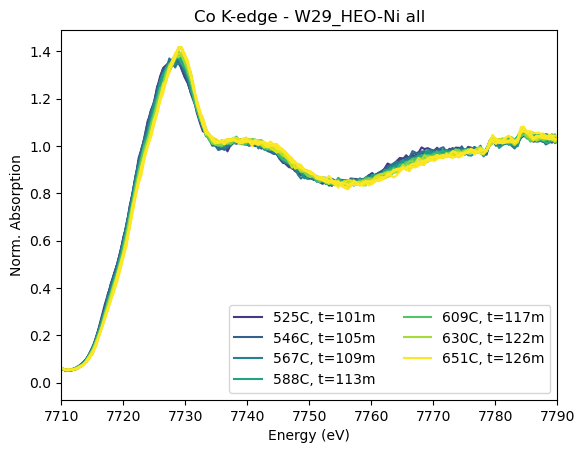

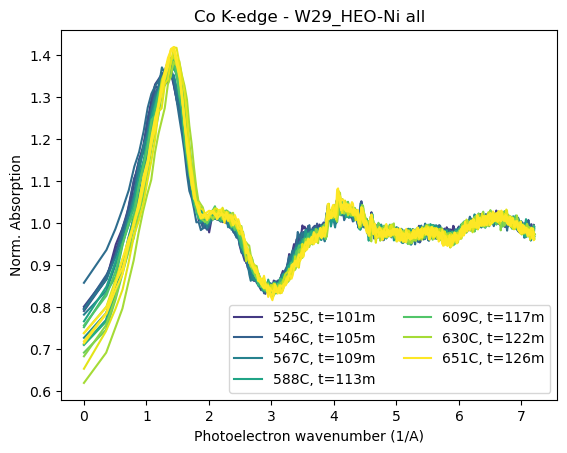

In [25]:
elem = 'Co'
name = 'W29_HEO-Ni'
condition = 'all' # 'heating' 'cooling' 'plateau' 'all' # choose spectra based on their temperature relative to previous
threshold = 6 # deg.C between adjacent spectra to decide whether heating/cooling is occurring
T_min = 500
T_max = 650
# time_min = 100 # this is only used if the appropriate "Condition to plot" line in plotspec() is uncommented
# time_max = 130
stride = 1
label_stride = 5 if condition == 'cooling' else 20 # modify this to suit your needs

if elem == 'Co':
    selected_data = CoSpecs[name]
elif elem == 'Zn':
    selected_data = ZnSpecs[name]

title = f'{elem} K-edge - {name} {condition}'

T_range = T_max - T_min

cmap = plt.cm.get_cmap('viridis')

def plotspec(mode='E'):
    '''this is only a function so I avoid copying it twice in this cell'''
    lastTemp = 0
    firsttime = 0
    # do the plotting thing
    condemned_groups = []
    for i, g in enumerate(selected_data):

        if i == 0:
            firsttime = g.time
            
        # a quick hack to remove poorly normalized spectra
        if np.max(g.norm) > 3 or np.min(g.norm) < -0.1:
            print('Warning: removed spectrum due to possible poor normalization.', g)
            condemned_groups.append(g)
            continue

        # skip if this group is not part of a ramp we're interested in
        c1 = condition == 'heating' and g.temperature < lastTemp + threshold
        c2 = condition == 'cooling' and g.temperature > lastTemp - threshold
        c3 = condition == 'plateau' and abs(g.temperature - lastTemp) > threshold
        lastTemp = g.temperature
        minutes = int(g.time - firsttime) // 60
        if i < 3 or c1 or c2 or c3:
            continue

        # Condition to plot ### UNCOMMENT THE ONE WE WANT TO USE ###
        if g.temperature > T_min and g.temperature < T_max and i % stride == 0:
        # if minutes > time_min and minutes < time_max:
            colorkey = (g.temperature - T_min) / T_range
            x = E_to_k(g.energy, g.e0) if mode == 'k' else g.energy
            l = f'{g.temperature:.0f}C, t={minutes}m' if i % (stride * label_stride) == 0 else None
            plt.plot(x, g.norm, label=l, color=cmap(colorkey))
            
    # as a side effect (yes, this is bad software design) also remove poorly normalized groups from selected_data
    for bad in condemned_groups:
        selected_data.remove(bad)
            
plotspec(mode='E')

plt.title(title)
plt.xlim(left=edges[elem] - 20)
# plt.xlim(7710, 7790)
plt.xlabel('Energy (eV)')
plt.ylabel('Norm. Absorption')
# plt.ylim((y_min, y_max))
plt.legend(ncol=2,loc='lower right')
# plt.savefig(os.path.join('Output/BM23/diffs', title), dpi=300)
plt.show()

plotspec(mode='k')

plt.title(title)
plt.xlabel('Photoelectron wavenumber (1/A)')
plt.ylabel('Norm. Absorption')
# plt.ylim((y_min, y_max))
plt.legend(ncol=2,loc='lower right')
# plt.savefig(os.path.join('Output/BM23/diffs', title + '_k'), dpi=300)
plt.show()

# Differential spectra

In [7]:
def diffs(spectra, wavenumbers, wavenumber_window):
    """Raw differences between spectra."""
    diffs = []
    mask = np.logical_and(wavenumbers > wavenumber_window[0], wavenumbers < wavenumber_window[1])
    for i in range(len(spectra) - 1):
        diffs.append(mask * (spectra[i + 1] - spectra[i]))
    return np.array(diffs)
        
def total_abs_diffs(spectra, wavenumbers, wavenumber_window=(2.5, 8)):
    """Args:
        - spectra (2d array-like): list of normalized absorption spectra, in order
        - wavenumbers (array-like): array of the wavenumbers corresponding to points in spectra, used
            to crop based on the window
        - wavenumber_window (tuple): min, max wavenumber to be accounted in sums
    Returns:
        - (array-like) total absolute differences between the normalized spectra
            from one to the next within wavenumber_window"""
    abs_differences = np.abs(diffs(spectra, wavenumbers, wavenumber_window))
    return np.sum(abs_differences, axis=1)

def noise_reduction(spectra, sg_window_E=11, sg_window_t=9):
    """Args:
        - spectra (2d array)
        - sg_window_E (int): Length of energy (axis 1) window for Savitzky-Golay filter
        - sg_window_t (int): Length of time (axis 0) window for Savitzky-Golay filter
    Returns:
        - 2D-filtered (see fastosh manual 'Two-D filtering') with nearest boundary condition"""
    X = np.array(spectra)
    X1 = savgol_filter(X, window_length=sg_window_t, polyorder=2, axis=0, mode='nearest')
    return savgol_filter(X1, window_length=sg_window_E, polyorder=2, axis=1, mode='nearest')

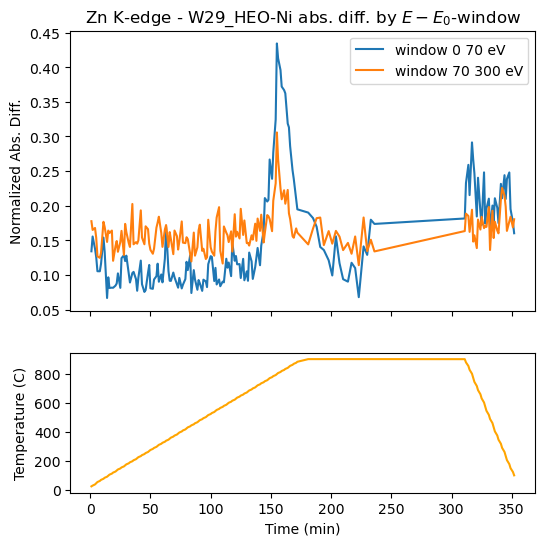

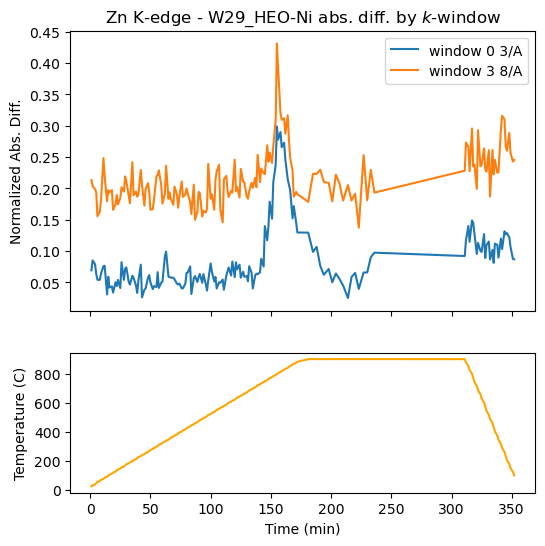

In [9]:
# NOTE: k values calculated w.r.t. the FIRST spectrum's E0 obtained from larch, 
# while E-E0 uses standard E0 from element information.
# This is IN CONTRAST TO the "Absorption as a function of temperature plots," where
# the k values are obtained using EACH spectrum's E0, making those sensitive to 
# changes in how larch interprets the white line from one spectrum to the next.

kwindow1 = (0, 3)
kwindow2 = (3, 8)
Ewindow1 = (0, 70)
Ewindow2 = (70, 300)

spectra = [g.norm for g in selected_data]

# Calculations
wavenumbers = np.array(E_to_k(selected_data[0].energy, selected_data[0].e0))
energies = selected_data[0].energy
temperatures = np.array([g.temperature for g in selected_data][1:])
raw_times = np.array([g.time - selected_data[0].time for g in selected_data][1:]).astype(int)
times = raw_times // 60

filtered_spectra = noise_reduction(spectra, 16, 16)
k_abs_diffs_1 = total_abs_diffs(filtered_spectra, wavenumbers, kwindow1)
k_abs_diffs_2 = total_abs_diffs(filtered_spectra, wavenumbers, kwindow2)
E_abs_diffs_1 = total_abs_diffs(filtered_spectra, energies - edges[elem], Ewindow1)
E_abs_diffs_2 = total_abs_diffs(filtered_spectra, energies - edges[elem], Ewindow2)

# Saving to file
title2 = f'{elem} K-edge - {name}'
filename = f'{elem} K-edge - {name} abs'

# df = pd.DataFrame()
# df['timestamp s'] = raw_times
# df['temperatures C'] = temperatures
# df['diff 0 3 A-1'] = k_abs_diffs_1
# df['diff 3 8 A-1'] = k_abs_diffs_2
# df['diff 0 70 eV'] = E_abs_diffs_1
# df['diff 70 300 eV'] = E_abs_diffs_2

# df.to_csv(os.path.join('Output/BM23/', filename) + '.csv')

# Note: to crop the data, set these slices:
start = 0
end = -1

# Plotting E
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6), gridspec_kw={'height_ratios': [2,1]})
ax1.plot(times[start:end], E_abs_diffs_1[start:end], label='window 0 70 eV')
ax1.plot(times[start:end], E_abs_diffs_2[start:end], label='window 70 300 eV')
ax1.set(xticklabels=[])
# ax1.set_ylim(0,0.01)
ax1.set_title(title2 + ' abs. diff. by $E-E_0$-window')
ax1.set_ylabel("Normalized Abs. Diff.")
ax2.plot(times[start:end], temperatures[start:end], color='orange')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature (C)")
ax1.legend()

#plt.savefig(os.path.join('Output/BM23/diffs', filename), dpi=300)
plt.show()

# Plotting k
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6), gridspec_kw={'height_ratios': [2,1]})
ax1.plot(times[start:end], k_abs_diffs_1[start:end], label='window 0 3/A')
ax1.plot(times[start:end], k_abs_diffs_2[start:end], label='window 3 8/A')
ax1.set(xticklabels=[])
# ax1.set_ylim(0,0.01)
ax1.set_title(title2 + ' abs. diff. by $k$-window')
ax1.set_ylabel("Normalized Abs. Diff.")
ax2.plot(times[start:end], temperatures[start:end], color='orange')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature (C)")
ax1.legend()

#plt.savefig(os.path.join('Output/BM23/diffs', filename + '_k'), dpi=300)
plt.show()

# Differential "spectrogram"

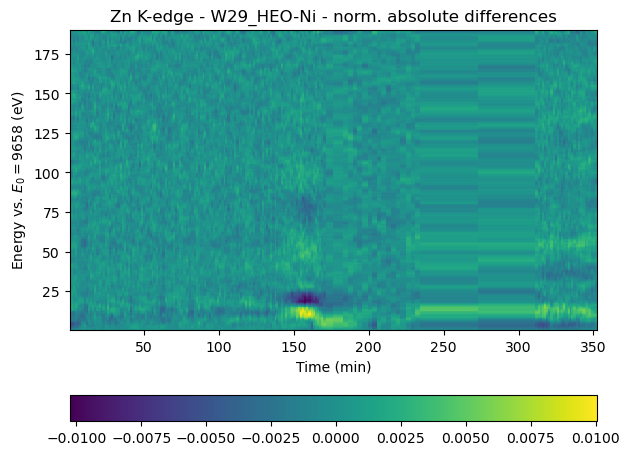

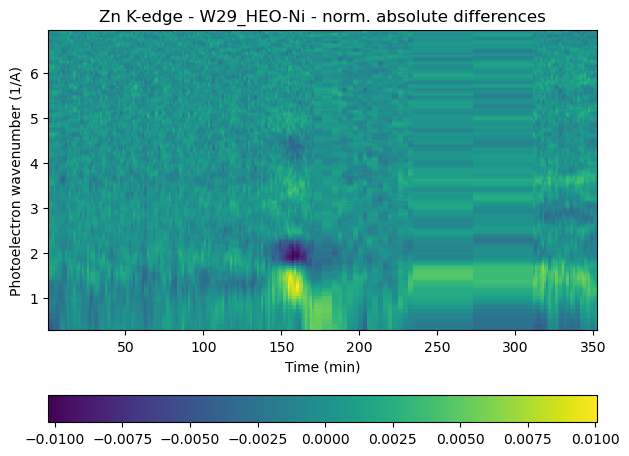

In [11]:
# Note this depends on variables in cells above. Re-run those from "Absorption as..." 
# each time we change which file we're reading.
fnk = filename + ' kspec'
fnE = filename + ' Espec'

k_difference_array = diffs(filtered_spectra, E_to_k(selected_data[0].energy, selected_data[0].e0), (0,8))
k_idx = np.argwhere(np.all(k_difference_array[..., :] == 0, axis=0))
k_diff_clipped = np.delete(k_difference_array, k_idx, axis=1)[start:end].transpose()
k_clipped = np.delete(E_to_k(selected_data[0].energy, selected_data[0].e0), k_idx)

E_difference_array = diffs(filtered_spectra, selected_data[0].energy - edges[elem], (0,300))
E_idx = np.argwhere(np.all(E_difference_array[..., :] == 0, axis=0))
E_diff_clipped = np.delete(E_difference_array, E_idx, axis=1)[start:end].transpose()
E_clipped = np.delete(selected_data[0].energy - edges[elem], E_idx)

plt.pcolor(times[start:end], E_clipped, E_diff_clipped)
plt.colorbar(orientation='horizontal')
plt.xlabel('Time (min)')
plt.ylabel(f'Energy vs. $E_0=${edges[elem]} (eV)')
plt.title(f'{elem} K-edge - {name} - norm. absolute differences')
plt.tight_layout()
# plt.savefig(os.path.join('Output/BM23/diffs', fnE), dpi=500)
plt.show()

plt.pcolor(times[start:end], k_clipped, k_diff_clipped)
plt.colorbar(orientation='horizontal')
plt.xlabel('Time (min)')
plt.ylabel(f'Photoelectron wavenumber (1/A)')
plt.title(f'{elem} K-edge - {name} - norm. absolute differences')
plt.tight_layout()
# plt.savefig(os.path.join('Output/BM23/diffs', fnk), dpi=500)
plt.show()